In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import matplotlib.pyplot as plt
import torchattacks

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset_orig = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainset, valset = random_split(trainset_orig, (0.8, 0.2))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
conv_block_maker = lambda in_c, out_c, k_s, s, p: nn.Sequential(
    nn.Conv2d(in_c, out_c, k_s, s, p),
    nn.BatchNorm2d(out_c),
    nn.ReLU(),
)

inception_block_maker = lambda in_c, filt_1, filt_3, filt_5, filt_3_r, filt_5_r, p: [
    conv_block_maker(in_c, filt_1, 1, 1, 0), #block 1

    nn.Sequential(conv_block_maker(in_c, filt_3_r, 1, 1, 0), #block 2
    conv_block_maker(filt_3_r, filt_3, 3, 1, 1)), #block 2
    
    nn.Sequential(conv_block_maker(in_c, filt_5_r, 1, 1, 0), #block 3
    conv_block_maker(filt_5_r, filt_5, 5, 1, 2)), #block 3

    nn.Sequential(nn.MaxPool2d((3,3), (1,1), (1,1)),
    conv_block_maker(in_c, p, 1, 1, 0)), #block 4
]

class inception_block(nn.Module):
    def __init__(self, in_c, filt_1, filt_3, filt_5, filt_3_r, filt_5_r, p):
        super(inception_block, self).__init__()
        self.block_1 = conv_block_maker(in_c, filt_1, 1, 1, 0)
        self.block_2 = nn.Sequential(conv_block_maker(in_c, filt_3_r, 1, 1, 0), #block 2
    conv_block_maker(filt_3_r, filt_3, 3, 1, 1))
        self.block_3 = nn.Sequential(conv_block_maker(in_c, filt_5_r, 1, 1, 0), #block 3
    conv_block_maker(filt_5_r, filt_5, 5, 1, 2))
        self.block_4 = nn.Sequential(nn.MaxPool2d((3,3), (1,1), (1,1)),
    conv_block_maker(in_c, p, 1, 1, 0))
    def forward(self, t):
        First_Block_Out = self.block_1(t)
        Second_Block_Out = self.block_2(t)
        Third_Block_Out = self.block_3(t)
        Fourth_Block_Out = self.block_4(t)
        return torch.cat([First_Block_Out,Second_Block_Out, Third_Block_Out, Fourth_Block_Out], dim=1)

aux_class = lambda in_c,num_c: nn.Sequential(
    nn.AdaptiveAvgPool2d((4,4)),
    nn.Conv2d(in_c, 128, 1, 1, 0),
    nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(2048,1024),
    nn.Dropout(0.7),
    nn.Linear(1024, num_c),
)

class inception_model(nn.Module):
    def __init__(self, out_c):
        super(inception_model, self).__init__()
        self.block_1 = nn.Sequential(
            conv_block_maker(3,64,7,2,3),
            nn.MaxPool2d((3,3),stride=2,padding=0,ceil_mode =True),
            conv_block_maker(64,64,1,1,0),
            conv_block_maker(64,192,3,1,1),
            nn.MaxPool2d((3,3),stride=2,padding=0,ceil_mode =True),
            inception_block(192,64,128,32,96,16,32),
            inception_block(256,128,192,96,128,32,64),
            nn.MaxPool2d((3,3),stride=2,padding=0,ceil_mode =True),
            inception_block(480,192,208,48,96,16,64),)
        self.block_2 = nn.Sequential(
            inception_block(512,160,224,64,112,24,64),
            inception_block(512,128,256,64,128,24,64),
            inception_block(512,112,288,64,144,32,64),)
        self.block_3 = nn.Sequential(
            inception_block(528,256,320,128,160,32,128),
            nn.MaxPool2d((3,3),stride=2,padding=0,ceil_mode =True),
            inception_block(832,256,320,128,160,32,128),
            inception_block(832,384,384,128,192,48,128),
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Flatten(1),
            nn.Dropout(p=0.4),
            nn.Linear(in_features =1024,out_features = out_c))
        self.aux_1 = aux_class(512,out_c)
        self.aux_2 = aux_class(528,out_c)
    def forward(self, t):
        t = self.block_1(t)
        aux_1_out = self.aux_1(t)
        t = self.block_2(t)
        aux_2_out = self.aux_2(t)
        t = self.block_3(t)
        if self.training:
            return t, aux_1_out, aux_2_out
        else:
            return t

In [5]:
Device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
def Train_Validate_Model(Model, Train_Loader, Val_Loader, Num_Of_Train_Samples, Num_Of_Val_Samples, Criterion,Optimizer, Num_Epochs):
    # ==========================Training Part ================================#
    Train_Loss_History, Train_Accuracy_History, Val_Loss_History, Val_Accuracy_History = [], [], [], []
    for epoch in (pbar:=tqdm(range(Num_Epochs))):
        Num_Of_Predicted_Correctly, Train_Cummulative_Loss = 0, 0
        for batch_samples,targets in Train_Loader:
            batch_samples = batch_samples.to(device=Device)
            targets = targets.to(device=Device)

            Network_Predictions, Aux_1_Predictions, Aux_2_Predictions = Model(batch_samples)
            Main_Loss =  Criterion(Network_Predictions, targets) + (0.3 * Criterion(Aux_1_Predictions, targets)) + (0.3 * Criterion(Aux_2_Predictions, targets))

            Optimizer.zero_grad() 
            Main_Loss.backward() 
            Optimizer.step()
            
            _, Train_Samples_Predictions = Network_Predictions.max(1)
            Train_Samples_Predictions = Train_Samples_Predictions.to(device=Device)
            Num_Of_Predicted_Correctly += (Train_Samples_Predictions == targets).float().sum().item()
            Train_Cummulative_Loss += Main_Loss.data.item() * batch_samples.shape[0]
            
        Train_Cummulative_Loss /= Num_Of_Train_Samples
        Train_Loss_History.append(Train_Cummulative_Loss)
        Train_Accuracy = Num_Of_Predicted_Correctly / Num_Of_Train_Samples
        Train_Accuracy_History.append(Train_Accuracy)
    # =============================== End of Training Part ========================#
    
    #============================ Validation Part ===================================#
    
        Num_Of_Predicted_Correctly = 0
        with torch.no_grad(): # we're in test mode so we don't need to calc the gradients
            Val_Cummulative_Loss = 0
            for batch_samples,targets in Val_Loader:
                batch_samples = batch_samples.to(device=Device)
                targets = targets.to(device=Device)

                Network_Predictions, Aux_1_Predictions, Aux_2_Predictions = Model(batch_samples)

                Main_Loss = Criterion(Network_Predictions, targets) + (0.3 *  Criterion(Aux_1_Predictions, targets)) + (0.3 * Criterion(Aux_2_Predictions, targets))

                _, Val_Samples_Predictions = Network_Predictions.max(1)
                Val_Samples_Predictions = Val_Samples_Predictions.to(device=Device)
                Num_Of_Predicted_Correctly += (Val_Samples_Predictions == targets).float().sum().item()
                Val_Cummulative_Loss += Main_Loss.data.item() * batch_samples.shape[0]
            
            Val_Cummulative_Loss /= Num_Of_Val_Samples
            Val_Loss_History.append(Val_Cummulative_Loss)
            Val_Accuracy = Num_Of_Predicted_Correctly / Num_Of_Val_Samples
            Val_Accuracy_History.append(Val_Accuracy)
            # =============================== End of Validation Part ========================#

            pbar.set_description(f"train-loss:{Train_Cummulative_Loss},train=acc:{Train_Accuracy},val-loss:{Val_Cummulative_Loss},val-loss:{Val_Accuracy}")
            if epoch % 10 == 0:
                print()
    torch.save(Model.state_dict(), "InceptionNet_Model")
    return Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History

In [10]:
def Train_Validate_Model_Adversarial_Training(Model, Train_Loader, Val_Loader, Num_Of_Train_Samples, Num_Of_Val_Samples, Criterion,Optimizer, Num_Epochs, epsilon):
    # ==========================Training Part ================================#
    Train_Loss_History, Train_Accuracy_History, Val_Loss_History, Val_Accuracy_History = [], [], [], []
    for epoch in (pbar:=tqdm(range(Num_Epochs))):
        Num_Of_Predicted_Correctly, Train_Cummulative_Loss = 0, 0
        for batch_samples,targets in Train_Loader:
            batch_samples = batch_samples.to(device=Device)
            targets = targets.to(device=Device)

            batch_samples.requires_grad = True
            Network_Predictions, Aux_1_Predictions, Aux_2_Predictions = Model(batch_samples)
            Main_Loss =  Criterion(Network_Predictions, targets) + (0.3 * Criterion(Aux_1_Predictions, targets)) + (0.3 * Criterion(Aux_2_Predictions, targets))

            #Find the loss of unperturbed data and step
            Optimizer.zero_grad() 
            Main_Loss.backward() 
            Optimizer.step()

            #Alter the data with FGSM attack
            batch_grad = batch_samples.grad.data
            batch_samples_perturbed = torch.clamp(batch_samples + epsilon * batch_grad.sign(), 0, 1)

            #Calculate new loss and step
            Network_Predictions, Aux_1_Predictions, Aux_2_Predictions = Model(batch_samples_perturbed)
            Main_Loss =  Criterion(Network_Predictions, targets) + (0.3 * Criterion(Aux_1_Predictions, targets)) + (0.3 * Criterion(Aux_2_Predictions, targets))

            Optimizer.zero_grad()
            Main_Loss.backward()
            Optimizer.step()
            
            _, Train_Samples_Predictions = Network_Predictions.max(1)
            Train_Samples_Predictions = Train_Samples_Predictions.to(device=Device)
            Num_Of_Predicted_Correctly += (Train_Samples_Predictions == targets).float().sum().item()
            Train_Cummulative_Loss += Main_Loss.data.item() * batch_samples.shape[0]
            
        Train_Cummulative_Loss /= Num_Of_Train_Samples
        Train_Loss_History.append(Train_Cummulative_Loss)
        Train_Accuracy = Num_Of_Predicted_Correctly / Num_Of_Train_Samples
        Train_Accuracy_History.append(Train_Accuracy)
    # =============================== End of Training Part ========================#
    
    #============================ Validation Part ===================================#
    
        Num_Of_Predicted_Correctly = 0
        with torch.no_grad(): # we're in test mode so we don't need to calc the gradients
            Val_Cummulative_Loss = 0
            for batch_samples,targets in Val_Loader:
                batch_samples = batch_samples.to(device=Device)
                targets = targets.to(device=Device)

                Network_Predictions, Aux_1_Predictions, Aux_2_Predictions = Model(batch_samples)

                Main_Loss = Criterion(Network_Predictions, targets) + (0.3 *  Criterion(Aux_1_Predictions, targets)) + (0.3 * Criterion(Aux_2_Predictions, targets))

                _, Val_Samples_Predictions = Network_Predictions.max(1)
                Val_Samples_Predictions = Val_Samples_Predictions.to(device=Device)
                Num_Of_Predicted_Correctly += (Val_Samples_Predictions == targets).float().sum().item()
                Val_Cummulative_Loss += Main_Loss.data.item() * batch_samples.shape[0]
            
            Val_Cummulative_Loss /= Num_Of_Val_Samples
            Val_Loss_History.append(Val_Cummulative_Loss)
            Val_Accuracy = Num_Of_Predicted_Correctly / Num_Of_Val_Samples
            Val_Accuracy_History.append(Val_Accuracy)
            # =============================== End of Validation Part ========================#

            pbar.set_description(f"train-loss:{Train_Cummulative_Loss},train=acc:{Train_Accuracy},val-loss:{Val_Cummulative_Loss},val-loss:{Val_Accuracy}")
            if epoch % 10 == 0:
                print()
    torch.save(Model.state_dict(), "InceptionNet_Model_Adversarial_Training")
    return Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History

In [11]:
def Plot_Model_History(Train_Accuracy_History , Val_Accuracy_History, Train_Loss_History, Val_Loss_History):
    # plot Accuracy
    plt.plot(Train_Accuracy_History, marker='o')
    plt.plot(Val_Accuracy_History, marker='o')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # plot Loss
    plt.plot(Train_Loss_History, marker='8')
    plt.plot(Val_Loss_History, marker='8')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

train-loss:2.7681100681304933,train=acc:0.36595,val-loss:2.5625043197631836,val-loss:0.4321:   1%|          | 1/100 [00:16<27:23, 16.60s/it]

train-loss:0.7622951854705811,train=acc:0.840425,val-loss:2.2025031591415405,val-loss:0.6201:  11%|█         | 11/100 [03:00<24:12, 16.31s/it]

train-loss:0.25814852230548857,train=acc:0.9463,val-loss:3.235925350189209,val-loss:0.6213:  21%|██        | 21/100 [05:47<21:36, 16.41s/it]  

train-loss:0.15299868675470352,train=acc:0.96955,val-loss:3.5064580444335935,val-loss:0.6232:  31%|███       | 31/100 [08:29<18:32, 16.12s/it] 

train-loss:0.12611995956897737,train=acc:0.9749,val-loss:3.839527028656006,val-loss:0.6176:  41%|████      | 41/100 [11:17<16:05, 16.36s/it]  

train-loss:0.09981379981935025,train=acc:0.979775,val-loss:3.9976223831176756,val-loss:0.6274:  51%|█████     | 51/100 [13:57<13:05, 16.02s/it]

train-loss:0.08278256120085717,train=acc:0.983975,val-loss:4.450044944000244,val-loss:0.6076:  61%|██████    | 61/100 [16:44<10:54, 16.78s/it] 

train-loss:0.07364257708638906,train=acc:0.98565,val-loss:4.351101194000244,val-loss:0.6223:  71%|███████   | 71/100 [19:36<08:20, 17.25s/it] 

train-loss:0.05834821802955121,train=acc:0.989275,val-loss:4.746673381042481,val-loss:0.6179:  81%|████████  | 81/100 [23:37<08:48, 27.83s/it] 

train-loss:0.05607848562672734,train=acc:0.98985,val-loss:4.373763639831543,val-loss:0.6335:  91%|█████████ | 91/100 [28:07<04:08, 27.61s/it] 

train-loss:0.047099580313265325,train=acc:0.99125,val-loss:4.634147099685669,val-loss:0.6221: 100%|██████████| 100/100 [32:27<00:00, 19.47s/it]


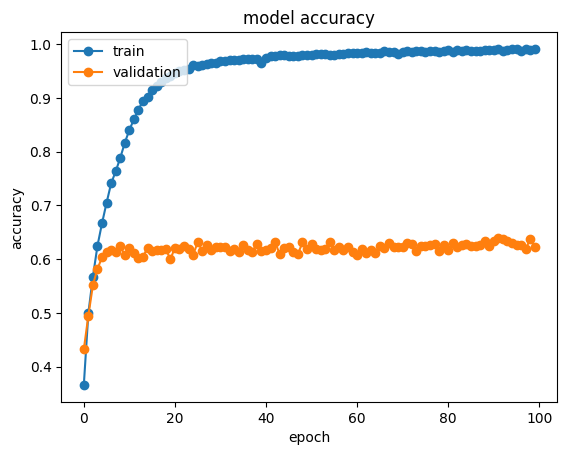

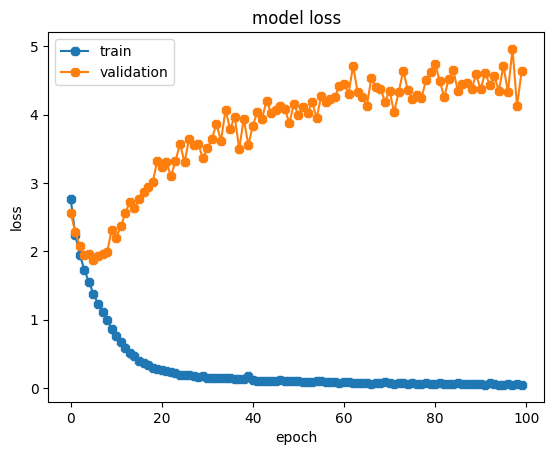

In [12]:
def Propagate_Network(AT_flag, epsilon = .001):
    Inception_Model = inception_model(out_c=10).to(device=Device)
    Cross_Entropy_Criterion = nn.CrossEntropyLoss()
    Adam_Optimizer = optim.Adam(Inception_Model.parameters(), lr=0.001)

    if AT_flag == 1:
        Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History = Train_Validate_Model_Adversarial_Training(Model = Inception_Model, Train_Loader = trainloader,Val_Loader = valloader,Num_Of_Train_Samples = len(trainset),
                            Num_Of_Val_Samples = len(valset),Criterion = Cross_Entropy_Criterion,Optimizer = Adam_Optimizer,Num_Epochs = 100, epsilon=.001)
    else:
        Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History = Train_Validate_Model(Model = Inception_Model, Train_Loader = trainloader,Val_Loader = valloader,Num_Of_Train_Samples = len(trainset),
                            Num_Of_Val_Samples = len(valset),Criterion = Cross_Entropy_Criterion,Optimizer = Adam_Optimizer,Num_Epochs = 100)
    Plot_Model_History( Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History)
Propagate_Network(1, .001)

In [11]:
def Model_Test(Test_Loader, model_name, Num_Of_Test_Samples):
    Test_CIFAR = inception_model(out_c=10).to(device=Device)
    Test_CIFAR.load_state_dict(torch.load(model_name))
    Test_CIFAR.eval().to(Device)
    Num_Of_Correct_Predicted = 0
    with torch.no_grad():
        for batch_samples,targets in tqdm(Test_Loader):
            batch_samples, targets = batch_samples.to(Device), targets.to(Device)
            # Model Predictions
            Predictions = Test_CIFAR(batch_samples)
            
            _, Predicted_Class = Predictions.max(1)
            
            # Calc number of samples that predicted correctly
            Num_Of_Correct_Predicted += (Predicted_Class == targets).float().sum().item()
    Test_Accuracy = Num_Of_Correct_Predicted / Num_Of_Test_Samples
    print("Test Accuracy = ", Test_Accuracy*100 , "%")
Model_Test(Test_Loader= testloader, model_name='./InceptionNet_Model', Num_Of_Test_Samples=10000)
Model_Test(Test_Loader= testloader, model_name='./InceptionNet_Model_Adversarial_Training', Num_Of_Test_Samples=10000)

100%|██████████| 79/79 [00:08<00:00,  9.83it/s]

Test Accuracy =  77.71000000000001 %


In [12]:
Test_CIFAR = inception_model(out_c=10)#.to(device=Device);
Test_CIFAR.load_state_dict(torch.load('./InceptionNet_Model'))
Test_CIFAR.eval();#.to(Device);

In [16]:
def eval_attacks(attack, model, att_name):
        images = ((torch.stack([transform(i) for i in testset.data]) + 1) / 2)
        adv_images = (attack(images, torch.Tensor(testset.targets).long()))
        targets_all = np.array(testset.targets)

        Num_Of_Correct_Predicted = 0
        with torch.no_grad():
                for idx in zip(range(0,len(adv_images),128),range(128,len(adv_images)+128,128)):
                        batch_samples, targets = (adv_images[idx[0]:idx[1]]*2) - 1, torch.Tensor(targets_all[idx[0]:idx[1]])#.to(Device)
                #         # Model Predictions
                        Predictions = model(batch_samples)
                        
                        _, Predicted_Class = Predictions.max(1)
                        
                        # Calc number of samples that predicted correctly
                        Num_Of_Correct_Predicted += (Predicted_Class == targets).float().sum().item()
        Test_Accuracy = Num_Of_Correct_Predicted / 10000
        print(f"Test Accuracy with {att_name} attack = ", Test_Accuracy*100 , "%")

In [15]:
attacks = [
    torchattacks.VANILA(Test_CIFAR),
    torchattacks.GN(Test_CIFAR),
    torchattacks.FGSM(Test_CIFAR, eps=8/255),
    torchattacks.PGD(Test_CIFAR, eps=8/255, alpha = 2/255, random_start=True),
    torchattacks.CW(Test_CIFAR,  c=1, kappa=0),
]

No Adversarial Training

In [15]:
for a,n in zip(attacks,["VANILA","GN", "FGSM", "PGD", "CW"]):
    eval_attacks(a, Test_CIFAR, n)

Test Accuracy with VANILA attack =  77.72 %
Test Accuracy with GN attack =  70.62 %
Test Accuracy with FGSM attack =  44.91 %
Test Accuracy with PGD attack =  44.11 %
Test Accuracy with CW attack =  75.44 %


Adversarial Training

In [13]:
Test_CIFAR = inception_model(out_c=10)#.to(device=Device);
Test_CIFAR.load_state_dict(torch.load('./InceptionNet_Model_Adversarial_Training'))
Test_CIFAR.eval();#.to(Device);

In [17]:
for a,n in zip(attacks,["VANILA","GN", "FGSM", "PGD", "CW"]):
    eval_attacks(a, Test_CIFAR, n)

Test Accuracy with VANILA attack =  62.53999999999999 %
Test Accuracy with GN attack =  55.94 %
Test Accuracy with FGSM attack =  54.459999999999994 %
Test Accuracy with PGD attack =  55.85 %
Test Accuracy with CW attack =  61.94 %
